In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import random
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [2]:
ds = load_dataset(
    "thesofakillers/jigsaw-toxic-comment-classification-challenge",
    trust_remote_code=True,
)

In [3]:
ds.column_names

{'train': ['id',
  'comment_text',
  'toxic',
  'severe_toxic',
  'obscene',
  'threat',
  'insult',
  'identity_hate'],
 'test': ['id',
  'comment_text',
  'toxic',
  'severe_toxic',
  'obscene',
  'threat',
  'insult',
  'identity_hate']}

In [4]:
import pandas as pd

# Convert the dataset to a pandas DataFrame
df = ds["train"].to_pandas()
classification_labels = [
    c for c in ds.column_names["train"] if c not in ["id", "comment_text"]
]
df["num_labels_on"] = df[classification_labels].sum(axis=1)
category_buckets = {k: v for k, v in df.groupby("num_labels_on")}

In [5]:
category_buckets[4]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_labels_on
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,4
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,4
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1,4
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...
159096,f871b05d4caa6f20,"You filthy, stinking crow! \n\nI am back! Dirt...",1,1,1,0,1,0,4
159099,f885a3e2d779342e,now\n\nyou fucking pathetic moron. \n\ncc: Ji...,1,1,1,0,1,0,4
159312,fbf20e312cd4a78d,"Walter Mercado \n\nAntonio, quite frankly, you...",1,1,1,0,1,0,4
159336,fc3efa2f6f025f6d,"Oh, fuck off. The pansy Jew would just whine a...",1,0,1,0,1,1,4


Bucket sizes histogram:
Bucket 0: 143346 samples
Bucket 1: 6360 samples
Bucket 2: 3480 samples
Bucket 3: 4209 samples
Bucket 4: 1760 samples
Bucket 5: 385 samples
Bucket 6: 31 samples


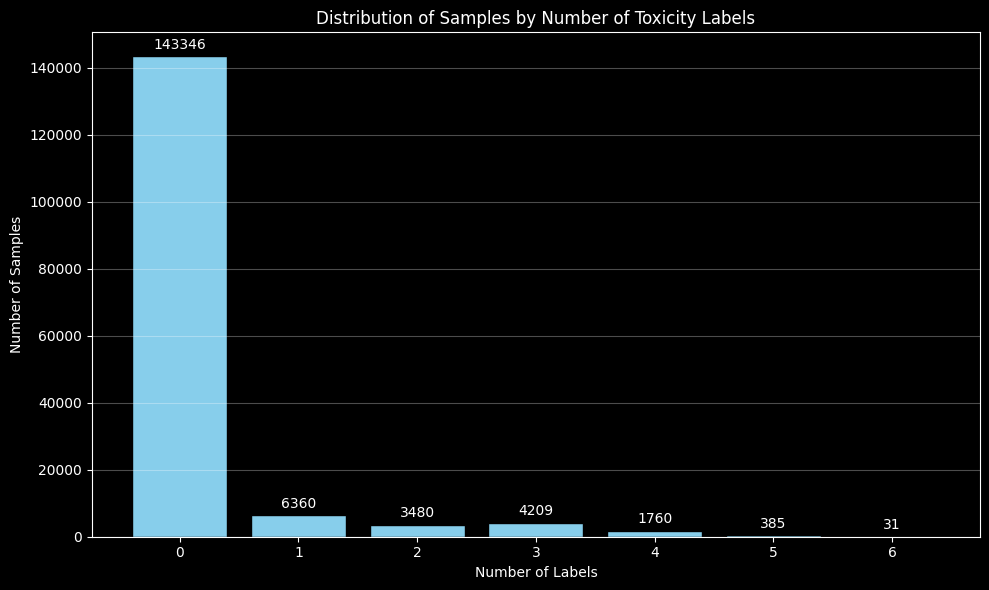

In [6]:
# Create histogram of bucket sizes and plot it
import matplotlib.pyplot as plt

bucket_sizes = {k: len(v) for k, v in category_buckets.items()}
print("Bucket sizes histogram:")
for bucket, size in sorted(bucket_sizes.items()):
    print(f"Bucket {bucket}: {size} samples")

# Plot the histogram
plt.figure(figsize=(10, 6))
buckets = list(bucket_sizes.keys())
sizes = list(bucket_sizes.values())

plt.bar(buckets, sizes, color="skyblue", edgecolor="black")
plt.xlabel("Number of Labels")
plt.ylabel("Number of Samples")
plt.title("Distribution of Samples by Number of Toxicity Labels")
plt.xticks(buckets)
plt.grid(axis="y", alpha=0.3)

for i, v in enumerate(sizes):
    plt.text(buckets[i], v + max(sizes) * 0.01, str(v), ha="center", va="bottom")

plt.tight_layout()
plt.show()

In [7]:
sample = category_buckets[5].sample(1).iloc[0]

In [8]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-160m-deduped")


def clean_tokens(text: str) -> list[str]:
    # Clean and tokenize the input text
    text = text.strip()
    encoded = tokenizer(text)
    token_ids = encoded["input_ids"]
    tokens = [tokenizer.decode(i) for i in token_ids]
    cleaned = [t.strip() for t in tokens if t.strip()]
    return cleaned


# Map the clean_tokens function to each category bucket
category_buckets_tokens = {}

for bucket_num, bucket_data in category_buckets.items():
    if bucket_num > 0:
        # Add cleaned_tokens column to each bucket DataFrame
        bucket_data["cleaned_tokens"] = bucket_data["comment_text"].apply(clean_tokens)
        # Apply clean_tokens to each row's comment_text in the bucket
        category_buckets_tokens[bucket_num] = bucket_data["comment_text"].apply(
            clean_tokens
        )


In [9]:
sample = category_buckets[3].sample(1).iloc[0]
cleaned = sample["cleaned_tokens"]
print(cleaned)

['you', 'will', 'block', 'me', 'you', 'filthy', 'coward', 'who', 'thinks', 'w', 'ikipedia', 'is', 'b', 'rit', 'ann', 'ica', 'en', 'cycl', 'opa', 'edia', 'in', '4', 'months', 'this', 'site', 'will', 'be', 'banned', 'by', 'US', 'G', 'OV', 'T', 'itself', 'and', 'you', 'will', 'ban', 'me', ',', 'i', 'will', 'fuck', 'your', 'mom', 'extremely', 'hard', '.', '122', '.', '161', '.', '78', '.', '118']


In [10]:
system_prompt = """
Classify each token in a given list as toxic or not, based on specific toxicity criteria, and provide the classification as a JSON object with a key called "classifications" containing a list of binary values. Only output the JSON object and no other extraneous text in the response.
Identify if each token matches any of the following toxicity criteria: '{toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'}. If a token matches any of these criteria, it should be classified as toxic (1), otherwise, it should be classified as not toxic (0).

# Steps

1. **Token Evaluation**: For each token, evaluate whether it falls under any of the given toxicity types.
2. **Classification**: Assign a binary value based on the evaluation:
    - 1 if the token matches any of the toxicity criteria.
    - 0 if the token does not match any of the toxicity criteria.
3. **Sequence Classification**: Determine if tAhe entire sequence matches any of the toxicity criteria: should be 1 if any of the tokens match the toxicity criteria, otherwise 0.
4. **Classification intensity**: Determine the intensity of the classification, assing a numeric value in range [0, 6] based on the number of activating toxicity criteria.

Output A JSON object with sequence level and token level classifications and intensity.

# Examples

**Input**: 
A list of tokens such as `["hello", "insult", "cat", "threat"]`.

**Output**: 
- `{"token_cls": [0, 1, 0, 1], "seq_cls": 1, "intensity": 2}`

**Explanation**:
- "hello" is not toxic (0).
- "insult" matches the criteria (1).
- "cat" is not toxic (0).
- "threat" matches the criteria (1).
- The intensity is 2 because "insult" and "threat" match the criteria.

# Notes

- Ensure all tokens are considered independently.
- The output list must match the input list's order in terms of position correspondence.
- Consider case sensitivity and common variations of toxic language within the decision process.
"""

system_prompt_noschema = (
    system_prompt
    + """
Output your JSON object without any other text based on this schema:

class ToxicityClassifier(BaseModel):
    token_cls: list[int]
    seq_cls: int
    intensity: int
"""
)

In [11]:
from openai import OpenAI
from pydantic import BaseModel
import json

client = OpenAI()


class ToxicityClassifier(BaseModel):
    token_cls: list[int]
    seq_cls: int
    intensity: int


def classify_toxicity(
    text: str, structured=False, model="gpt-4.1"
) -> ToxicityClassifier:
    if structured:
        response = client.beta.chat.completions.parse(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": str(cleaned)},
            ],
            response_format=ToxicityClassifier,
            max_tokens=2048,
        )
        return response.choices[0].message.parsed
    else:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt_noschema},
                {"role": "user", "content": str(cleaned)},
            ],
            max_tokens=2048,
        )
        obj = json.loads(response.choices[0].message.content)
        return ToxicityClassifier(**obj)


def print_toxicity_heatmap(tokens, token_cls):
    """Prints text with toxic tokens highlighted using ANSI escape codes"""
    highlighted = []
    for token, cls in zip(tokens, token_cls):
        if cls == 1:
            highlighted.append(f"\033[41m\033[97m{token}\033[0m")  # Red bg, white text
        else:
            highlighted.append(token)
    print(" ".join(highlighted))


In [12]:
obj = classify_toxicity(cleaned, structured=False, model="gpt-4.1-mini")
print("seq cls", obj.seq_cls)
print("intensity", obj.intensity)

print("ground truth intensity", sample["num_labels_on"])

print_toxicity_heatmap(cleaned, obj.token_cls)

seq cls 1
intensity 3
ground truth intensity 3
you will block me you filthy coward who thinks w ikipedia is b rit ann ica en cycl opa edia in 4 months this site will be banned by US G OV T itself and you will ban me , i will fuck your mom extremely hard . 122


In [13]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

nsamples = 100
bucket = 3


def process_sample(i):
    sample = category_buckets[bucket].sample(1).iloc[0]
    cleaned = sample["cleaned_tokens"]
    obj = classify_toxicity(cleaned, structured=False, model="gpt-4.1-mini")
    return {
        **sample.to_dict(),
        **{f"verifier_{key}_b{bucket}": json for key, json in obj.model_dump().items()},
    }


rows = []
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(process_sample, i) for i in range(nsamples)]
    for future in as_completed(futures):
        try:
            rows.append(future.result())
        except Exception as e:
            print(f"Error processing sample: {e}")

df = pd.DataFrame(rows)

In [27]:
idx = 1
bucket = 3
raw = {}
for key in ["token_cls", "seq_cls", "intensity"]:
    raw[key] = df.iloc[idx][f"verifier_{key}_b{bucket}"]
obj = ToxicityClassifier.model_validate(raw)
cleaned = df.iloc[idx]["cleaned_tokens"]
print_toxicity_heatmap(cleaned, obj.token_cls)
print("seq cls", obj.seq_cls)
print("intensity", obj.intensity)
print("ground truth intensity", df.iloc[1]["num_labels_on"])

You 're both a couple of ass holes . -
seq cls 1
intensity 3
ground truth intensity 3


In [28]:
df.iloc[idx]["comment_text"]

"You're both a couple of assholes. -"

In [30]:
df.to_parquet(f"assets/toxicity_verifiers_bucket_{bucket}.parquet")